# **Aprendizaje supervisado**
# SL06. Naive Bayes

Los modelos Naive Bayes son un grupo de algoritmos de clasificación extremadamente rápidos y simples que a menudo son adecuados para conjuntos de datos de muy alta dimensión.
Debido a que son tan rápidos y tienen tan pocos parámetros ajustables, terminan siendo muy útiles como un modelo base rápido para un problema de clasificación.
Esta sección se centrará en una explicación intuitiva de cómo funcionan los clasificadores de Bayes ingenuos, seguida de un par de ejemplos de ellos en acción en algunos conjuntos de datos.

## <font color='blue'>**Clasificación Bayesiana**</font>

Los **clasificadores Naive Bayes** se basan en métodos de clasificación Bayesianos.
Estos se basan en el teorema de Bayes, que es una ecuación que describe la relación de probabilidades condicionales de cantidades estadísticas.
En la clasificación bayesiana, estamos interesados ​​en encontrar la probabilidad de una etiqueta dadas algunas características observadas, que podemos escribir como $ P (L ~ | ~ {\rm características}) $.
El teorema de Bayes nos dice cómo expresar esto en términos de cantidades que podemos calcular más directamente:

$$
P (L ~ | ~ {\rm características}) = \frac {P ({\rm características} ~ | ~ L) P (L)} {P ({\rm características})}
$$

Si estamos tratando de decidir entre dos etiquetas, llamémoslas $ L_1 $ y $ L_2 $, entonces una forma de tomar esta decisión es calcular la razón de las probabilidades posteriores para cada etiqueta:

$$
\frac {P (L_1 ~ | ~ {\rm características})} {P (L_2 ~ | ~ {\rm características})} = \frac {P ({\rm características} ~ | ~ L_1)} {P ( {\rm características} ~ | ~ L_2)} \frac {P (L_1)} {P (L_2)}
$$

Todo lo que necesitamos ahora es algún modelo mediante el cual podamos calcular $ P ({\rm features} ~ | ~ L_i) $ para cada etiqueta.
Este modelo se denomina *modelo generativo* porque especifica el proceso aleatorio hipotético que genera los datos.
Especificar este modelo generativo para cada etiqueta es la pieza principal del entrenamiento de dicho clasificador bayesiano.
La versión general de este paso de formación es una tarea muy difícil, pero podemos simplificarla mediante el uso de algunas suposiciones simplificadoras sobre la forma de este modelo.

Aquí es donde entra el "ingenuo" en "Bayes ingenuo": si hacemos suposiciones muy ingenuas sobre el modelo generativo para cada etiqueta, podemos encontrar una aproximación aproximada del modelo generativo para cada clase, y luego proceder con la clasificación bayesiana .
Los diferentes tipos de clasificadores de Bayes ingenuos se basan en diferentes supuestos ingenuos sobre los datos, y examinaremos algunos de ellos en las siguientes secciones.

Comenzamos con las importaciones estándar:

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## <font color='blue'>**Gaussian Naive Bayes**</font>

Quizás el clasificador de Bayes ingenuo más fácil de entender es el Bayes ingenuo de Gauss.
En este clasificador, se supone que *los datos de cada etiqueta se extraen de una distribución gaussiana simple*.
Imagina que tienes los siguientes datos:

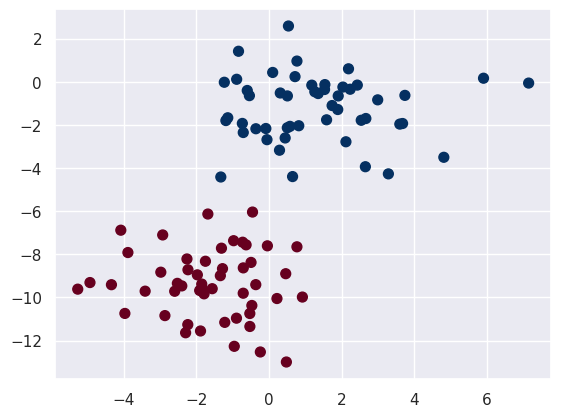

In [21]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Una forma extremadamente rápida de crear un modelo simple es asumir que los datos se describen mediante una distribución gaussiana sin covarianza entre dimensiones.
Este modelo se puede ajustar simplemente encontrando la desviación estándar y media de los puntos dentro de cada etiqueta, que es todo lo que necesita para definir dicha distribución.
El resultado de esta ingenua suposición gaussiana se muestra en la siguiente figura:

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.05-gaussian-NB.png?raw=1)


Las elipses aquí representan el modelo generativo gaussiano para cada etiqueta, con mayor probabilidad hacia el centro de las elipses.
Con este modelo generativo implementado para cada clase, tenemos una receta simple para calcular la probabilidad $ P ({\rm features} ~ | ~ L_1) $ para cualquier punto de datos, y así podemos calcular rápidamente la razón posterior y determinar qué etiqueta es la más probable para un punto dado.

Este procedimiento se implementa en el estimador ''sklearn.naive_bayes.GaussianNB'' de Scikit-Learn:

In [22]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Ahora generemos algunos datos nuevos y hagamos una prediccion de la etiqueta:

In [23]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Ahora podemos trazar estos nuevos datos para tener una idea de dónde está el límite de decisión:

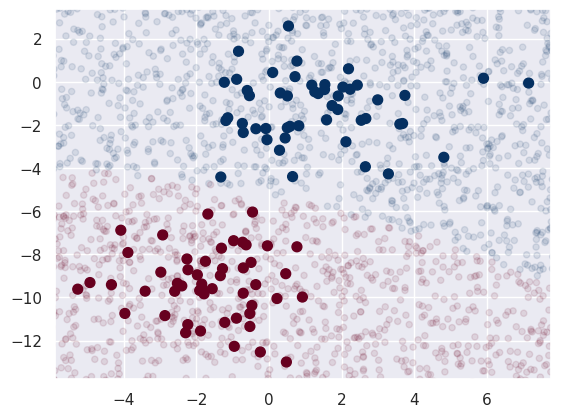

In [24]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

Vemos un límite ligeramente curvado en las clasificaciones; en general, el límite en el Bayes ingenuo de Gauss es cuadrático.

Una buena parte de este formalismo bayesiano es que, naturalmente, permite la clasificación probabilística, que podemos calcular utilizando el método ''predict_proba'':

In [25]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

Las columnas dan las probabilidades posteriores de la primera y segunda etiqueta, respectivamente.
Si está buscando estimaciones de incertidumbre en su clasificación, los enfoques bayesianos como este pueden ser un enfoque útil.

Por supuesto, la clasificación final solo será tan buena como los supuestos del modelo que la conducen, razón por la cual el Bayes ingenuo gaussiano a menudo no produce muy buenos resultados.
Aún así, en muchos casos, especialmente a medida que aumenta el número de características, esta suposición no es lo suficientemente perjudicial como para evitar que el Bayes ingenuo gaussiano sea un método útil.

## <font color='blue'>**Multinomial Naive Bayes**</font>

La suposición gaussiana que se acaba de describir no es de ninguna manera la única suposición simple que podría usarse para especificar la distribución generativa para cada etiqueta.
Otro ejemplo útil es el Bayes ingenuo multinomial, donde se supone que las características se generan a partir de una distribución multinomial simple.
La distribución multinomial describe la probabilidad de observar recuentos entre varias categorías y, por lo tanto, Bayes ingenuo multinomial es más apropiado para características que representan recuentos o tasas de recuento.

La idea es precisamente la misma que antes, excepto que en lugar de modelar la distribución de datos con el mejor ajuste gaussiano, modelamos la distribución de datos con una distribución multinomial de mejor ajuste.

### Ejemplo: Clasificacion de Texto

Un lugar donde a menudo se usa Bayes ingenuo multinomial es en la clasificación de texto, donde las características están relacionadas con el recuento de palabras o las frecuencias dentro de los documentos que se van a clasificar.
Aquí usaremos las funciones de recuento de palabras dispersas del corpus de 20 grupos de noticias para mostrar cómo podemos clasificar estos documentos breves en categorías.

Descarguemos los datos y echemos un vistazo a los nombres de los objetivos:

In [26]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Para simplificar aquí, seleccionaremos solo algunas de estas categorías y descargaremos el conjunto de entrenamiento y prueba:

In [27]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Aquí hay una entrada representativa de los datos:

In [28]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Para utilizar estos datos para el aprendizaje automático, necesitamos poder convertir el contenido de cada cadena en un vector de números.
Para esto usaremos el vectorizador TF-IDF, y crearemos un Pipeline que lo adjunte a un clasificador Bayes ingenuo multinomial:

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Con este Pipeline, podemos aplicar el modelo a los datos de entrenamiento y predecir etiquetas para los datos de prueba:

In [30]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Ahora que hemos predicho las etiquetas de los datos de prueba, podemos evaluarlas para conocer el rendimiento del estimador.
Por ejemplo, aquí está la matriz de confusión entre las etiquetas verdaderas y predichas para los datos de prueba:

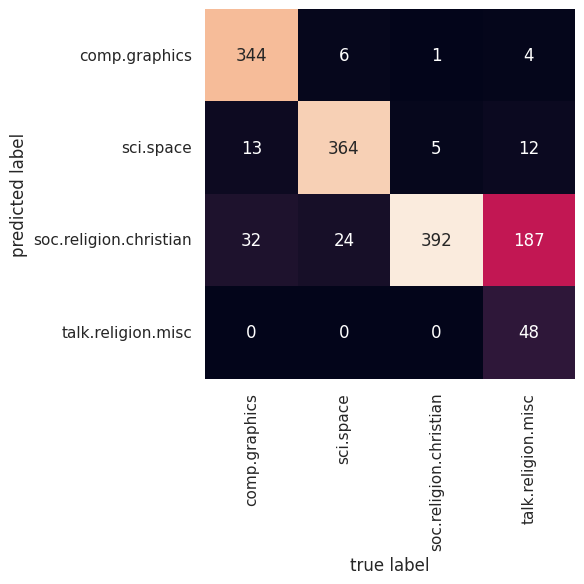

In [31]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidentemente, incluso este clasificador muy simple puede separar con éxito la conversación sobre espacio de la conversación sobre computadoras, pero se confunde entre hablar sobre religión y hablar sobre cristianismo.
¡Esta es quizás un área de confusión esperada!

Lo bueno aquí es que ahora tenemos las herramientas para determinar la categoría de * cualquier * cadena, usando el método `` predict () '' de este Pipeline.
Aquí hay una función de utilidad rápida que devolverá la predicción para una sola cadena:

In [32]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Probemos:

In [33]:
predict_category('sending a payload to the ISS')

'sci.space'

In [34]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [35]:
predict_category('determining the screen resolution')

'comp.graphics'

Recuerde que esto no es nada más sofisticado que un modelo de probabilidad simple para la frecuencia (ponderada) de cada palabra en la cadena; sin embargo, el resultado es sorprendente.
Incluso un algoritmo muy ingenuo, cuando se usa con cuidado y se entrena en un gran conjunto de datos de alta dimensión, puede ser sorprendentemente efectivo.

### ¿Cuándo usar Naive Bayes?

Debido a que los clasificadores bayesianos ingenuos hacen suposiciones tan estrictas sobre los datos, generalmente no funcionarán tan bien como un modelo más complicado.
Dicho esto, tienen varias ventajas:

- Son extremadamente rápidos tanto para el entrenamiento como para la predicción.
- Proporcionan una predicción probabilística sencilla
- A menudo son muy fáciles de interpretar.
- Tienen muy pocos (si los hay) parámetros ajustables

Estas ventajas significan que un clasificador bayesiano ingenuo suele ser una buena opción como clasificación inicial de referencia.
Si funciona adecuadamente, felicitaciones: tiene un clasificador muy rápido y muy interpretable para su problema.
Si no funciona bien, puede comenzar a explorar modelos más sofisticados, con un conocimiento básico de qué tan bien deberían funcionar.

Los clasificadores Naive Bayes tienden a funcionar especialmente bien en una de las siguientes situaciones:

- Cuando las suposiciones ingenuas realmente coinciden con los datos (muy raro en la práctica)
- Para categorías muy bien separadas, cuando la complejidad del modelo es menos importante
- Para datos de muy alta dimensión, cuando la complejidad del modelo es menos importante

Los dos últimos puntos parecen distintos, pero en realidad están relacionados: a medida que crece la dimensión de un conjunto de datos, es mucho menos probable que dos puntos se encuentren juntos (después de todo, deben estar cerca en *cada una de las dimensiones* para estar cerca en general).
Esto significa que los conglomerados en dimensiones altas tienden a estar más separados, en promedio, que los conglomerados en dimensiones bajas, asumiendo que las nuevas dimensiones realmente agregan información.
Por esta razón, los clasificadores simplistas como los ingenuos Bayes tienden a funcionar tan bien o mejor que los clasificadores más complicados a medida que aumenta la dimensionalidad: una vez que tiene suficientes datos, incluso un modelo simple puede ser muy poderoso.

## <font color='green'>Actividad 1</font>

Construiremos clasificadores utilizando modelos Bayesianos para el dataset de la flor iris.

In [36]:
from sklearn.datasets import load_iris
data = load_iris()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        15
           2       0.94      0.94      0.94        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



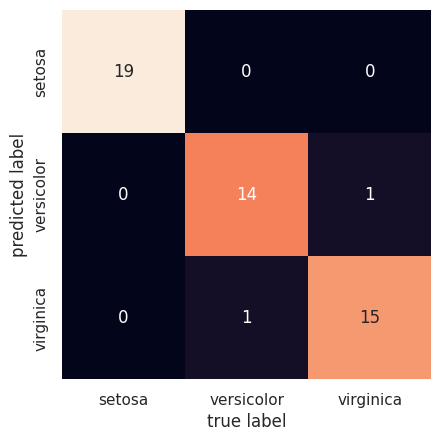

In [37]:
# Tu código aquí
# dividir el dataset en train y test para x e y
from sklearn.model_selection import train_test_split
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# usaremos GaussianNB
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train);


#probar el modelo
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

#plotear matriz de confusión
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# imprimir precisión, recall y f1
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


El modelo rindió muy bien en todas las métricas, y además fue MUY rápido.

<font color='green'>Fin Actividad 1</font>

# <font color='purple' style='bold' size=5>**EXPERIMENTO** </font>

Profundizaremos el contenido utilizando el modelo para predecir otro dataset categórico conocido, 'Penguins'

Exactitud del modelo: 0.96
Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       0.93      0.96      0.95        28
   Chinstrap       0.93      0.87      0.90        15
      Gentoo       1.00      1.00      1.00        24

    accuracy                           0.96        67
   macro avg       0.95      0.94      0.95        67
weighted avg       0.96      0.96      0.95        67



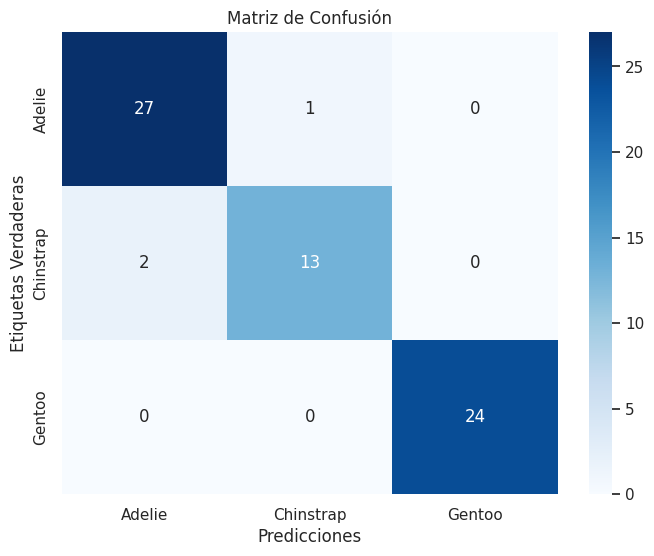

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
penguins = pd.read_csv(url)

# Preprocesamiento de datos
# Eliminar filas con valores faltantes
penguins = penguins.dropna()

# Seleccionar características relevantes y la variable objetivo
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Entrenar el modelo GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Realizar predicciones
y_pred = gnb.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy:.2f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gnb.classes_, yticklabels=gnb.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()


### <font color='purple'>**FIN EXPERIMENTO** </font>

# <font color='purple' style='bold' size=5>**MATERIAL ADICIONAL** </font>
##Material adicional para profundizar esta materia.

Aprende IA: Naive Bayes - Teoría

- Enlace: https://aprendeia.com/algoritmo-naive-bayes-machine-learning/

- Descripción: Explicación detallada de la teoría detrás de Naive Bayes, incluyendo su definición, suposiciones, ventajas y desventajas.

Aprende IA: Naive Bayes - Práctica con Python

- Enlace: https://aprendeia.com/naive-bayes-practica-con-python-machine-learning/

- Descripción: Guía práctica para implementar Naive Bayes en Python utilizando Scikit-learn, con ejemplos paso a paso.

DataCamp: Tutorial de Clasificación Naive Bayes con Scikit-learn

- Enlace: https://www.datacamp.com/es/tutorial/naive-bayes-scikit-learn

- Descripción: Tutorial interactivo que cubre la teoría y práctica de Naive Bayes, incluyendo ejemplos de código y visualizaciones.

### <font color='purple'>**FIN MATERIAL ADICIONAL** </font>